# 🧠 Intel Image Classification - ResNet50 Optimized for CPU (Surya Dwi Satria)

In [1]:
# ========= IMPORT LIBRARY YANG DIBUTUHKAN =========
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, roc_auc_score
import time



In [2]:
# ========= PARAMETER UTAMA =========
IMG_SIZE = 200
BATCH_SIZE = 32
SEED = 123

# ========= LOAD DATASET =========
dataset = image_dataset_from_directory(
    directory='seg_train/seg_train',
    labels='inferred',
    label_mode='int',
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=SEED
)




Found 14034 files belonging to 6 classes.


In [ ]:
# ========= SPLIT DATASET =========
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

val_size = int(0.2 * len(train_ds))
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

In [ ]:
# ========= PREPROCESSING (ResNet50) =========
def process(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.map(process,   num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(process,  num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

In [ ]:
#========= DATA AUGMENTATION =========
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),        # Membalik gambar secara horizontal
    layers.RandomRotation(0.2),             # Rotasi gambar ±20%
    layers.RandomZoom((-0.2, 0.0)),         # Zoom OUT maksimal 20% (nilai negatif)
    layers.RandomShear(0.2),                # Geser (shear) gambar sebesar 20%
], name="data_augmentation")

In [ ]:
# ========= MODEL RESNET50 =========
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# ========= KOMPILE MODEL =========
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
# ========= CALLBACKS =========
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
]
model.summary()

In [ ]:
# ========= TRAINING =========
start_train = time.time()
history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1, callbacks=callbacks)
end_train = time.time()
train_time = end_train - start_train

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.8122 - loss: 0.5120 - val_accuracy: 0.9018 - val_loss: 0.2578 - learning_rate: 3.0000e-04
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.8817 - loss: 0.3278 - val_accuracy: 0.9125 - val_loss: 0.2416 - learning_rate: 3.0000e-04
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.8857 - loss: 0.3058 - val_accuracy: 0.9210 - val_loss: 0.2279 - learning_rate: 3.0000e-04
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.9031 - loss: 0.2682 - val_accuracy: 0.9223 - val_loss: 0.2315 - learning_rate: 3.0000e-04
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9040 - loss: 0.2564 - val_accuracy: 0.9259 - val_loss: 0.2165 - learning_rate: 3.0000e-04
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.9090 - loss: 0.2445 - val_accuracy: 0.9286 - val_loss: 0.2148 - learning_rate: 3.0000e-04
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - acc

In [8]:
# ========= EVALUASI =========
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n🕒 Training Time: {train_time:.2f} detik")
print(f"✅ Test Accuracy: {test_acc:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9268 - loss: 0.2057

🕒 Training Time: 3940.18 detik
✅ Test Accuracy: 0.9268


In [3]:

# ========= METRIK LENGKAP =========

try :
    import pickle

    # Load kembali hasil dari file pickle
    with open("predictions.pkl", "rb") as f:
        data = pickle.load(f)

    y_true = data["y_true"]
    y_pred = data["y_pred"]
    y_pred_probs = data["y_pred_probs"]

    print("✅ Data prediksi berhasil dimuat!")
except FileNotFoundError:
    print("⚠️ File 'predictions.pkl' tidak ditemukan. Melakukan prediksi ulang...")
    # Ambil label asli
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    # Prediksi model
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Simpan hasil prediksi ke file pickle
    with open("predictions.pkl", "wb") as f:
        pickle.dump({
            "y_true": y_true,
            "y_pred": y_pred,
            "y_pred_probs": y_pred_probs
        }, f)
    print("✅ Hasil prediksi disimpan ke 'predictions.pkl'.")

# Ambil nama kelas dari dataset
class_names = dataset.class_names

# Ubah label numerik menjadi nama kelas
y_true_labels = [class_names[i] for i in y_true]
y_pred_labels = [class_names[i] for i in y_pred]

# Buat classification report dengan nama kelas
from sklearn.metrics import classification_report, roc_auc_score
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df[['precision','recall','f1-score']])

# ========= ROC-AUC (opsional) =========
try:
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    auc = roc_auc_score(y_true_bin, y_pred_probs, multi_class='ovr')
    print(f"ROC-AUC (macro): {auc:.4f}")
except Exception as e:
    print("ROC-AUC tidak dapat dihitung:", e)

✅ Data prediksi berhasil dimuat!
              precision    recall  f1-score
buildings      0.922383  0.953358  0.937615
forest         0.991213  0.992958  0.992084
glacier        0.899818  0.851724  0.875111
mountain       0.876623  0.907563  0.891825
sea            0.970642  0.963570  0.967093
street         0.949033  0.940767  0.944882
accuracy       0.934156  0.934156  0.934156
macro avg      0.934952  0.934990  0.934768
weighted avg   0.934309  0.934156  0.934028
ROC-AUC (macro): 0.9945


In [ ]:
# ========= TESTING AKHIR =========
fine_test_loss, fine_test_acc = model.evaluate(test_ds)
print(f"✅ Fine-tuned Test Accuracy: {fine_test_acc:.4f}")

# ========= METRIK LENGKAP =========
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df[['precision','recall','f1-score']])

try:
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=6)
    auc = roc_auc_score(y_true_bin, y_pred_probs, multi_class='ovr')
    print(f"ROC-AUC (macro): {auc:.4f}")
except:
    print("ROC-AUC tidak dapat dihitung")

88/88 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9268 - loss: 0.2057
✅ Fine-tuned Test Accuracy: 0.9268
88/88 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step
              precision    recall  f1-score
0              0.926437  0.930716  0.928571
1              0.981211  0.997877  0.989474
2              0.870690  0.859574  0.865096
3              0.880478  0.882236  0.881356
4              0.964758  0.962637  0.963696
5              0.940171  0.932203  0.936170
accuracy       0.926838  0.926838  0.926838
macro avg      0.927291  0.927541  0.927394
weighted avg   0.926612  0.926838  0.926703
ROC-AUC (macro): 0.9934


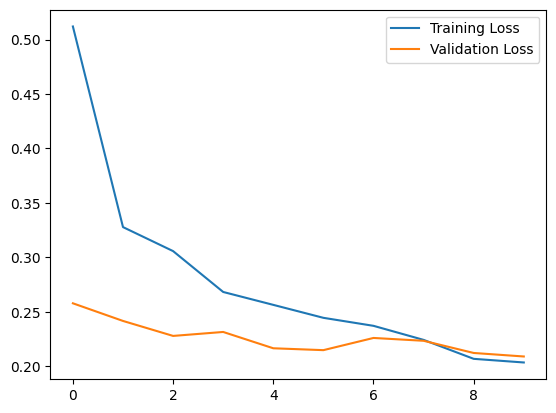

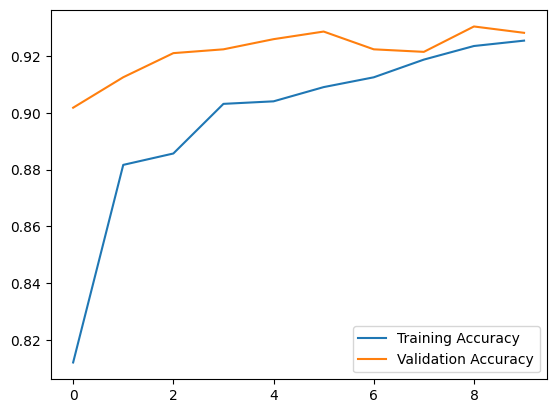

In [11]:
# ========= VISUALISASI =========
sns.lineplot(x=history.epoch, y=history.history['loss'], label='Training Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Validation Loss')
plt.show()

sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Training Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation Accuracy')
plt.show()

In [5]:


# ========= PREDIKSI FOLDER GAMBAR BARU =========
import os


pred_dir = "seg_pred/seg_pred"

# Ambil semua path gambar (format umum: jpg/png/jpeg)
image_paths = [
    os.path.join(pred_dir, fname)
    for fname in os.listdir(pred_dir)
    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Fungsi untuk load & preprocessing gambar
def load_and_prep_image(img_path, img_size=200):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0  # Normalisasi 0–1
    return img_array

# Ambil nama-nama kelas dari dataset training sebelumnya
class_names = dataset.class_names
print("Kelas terdeteksi:", class_names)

# ========= PROSES PREDIKSI =========
results = []  # list untuk menyimpan hasil prediksi

for img_path in image_paths:
    img = load_and_prep_image(img_path, img_size=200)
    preds = model.predict(img)
    
    pred_idx = np.argmax(preds)
    pred_class = class_names[pred_idx]
    confidence = np.max(preds) * 100
    
    results.append({
        "Nama File": os.path.basename(img_path),
        "Prediksi Kelas": pred_class,
        "Confidence (%)": round(confidence, 2)
    })

    # (Opsional) tampilkan contoh 1-2 gambar pertama
    if len(results) <= 2:
        plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
        plt.title(f"{pred_class} ({confidence:.1f}%)")
        plt.axis("off")
        plt.show()

# ========= EKSPOR KE CSV =========
df_results = pd.DataFrame(results)
output_path = "hasil_prediksi_resnet50.csv"
df_results.to_csv(output_path, index=False)

print(f"\n✅ Prediksi selesai! Total {len(results)} gambar diproses.")
print(f"Hasil disimpan ke: {output_path}")
df_results.head()


Kelas terdeteksi: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


NameError: name 'model' is not defined